# Calculate uncertainty on BTs (notebook)

### Import python package for plotting.

In [2]:
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be install via pip or conda.
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
import numpy as np
import pandas as pd
np.seterr('raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### Import pyrtlib package and tools

In [3]:
from pyrtlib.uncertainty import AbsModUncertainty, SpectroscopicParameter
from pyrtlib.atmospheric_profiles import AtmosphericProfiles as atmp
from pyrtlib.tb_spectrum import TbCloudRTE
from pyrtlib.utils import ppmv2gkg, mr2rh, get_frequencies, constants
from pyrtlib.uncertainty import covariance_matrix

In [4]:
atm = ['Tropical',
       'Midlatitude Summer',
       'Midlatitude Winter',
       'Subarctic Summer',
       'Subarctic Winter',
       'U.S. Standard']

### Define spectroscopic parameters to be perturbed

In [5]:
parameters = {**SpectroscopicParameter.oxygen_parameters('R18'), **SpectroscopicParameter.water_parameters('R17')}

parameters['O2S'].uncer = parameters['O2S'].value / 100
parameters['X05'].uncer = 0.05
parameters['WB300'].uncer = 0.05
parameters['O2gamma'].uncer[0: 34] = np.array([0.05      , 0.0138964 , 0.0138964 , 0.0138964 , 0.0138964 ,
                                    0.0138964 , 0.0138964 , 0.0138964 , 0.0138964 , 0.0138964 ,
                                    0.0138964 , 0.0138964 , 0.0138964 , 0.0138964 , 0.0138964 ,
                                    0.0138964 , 0.0138964 , 0.0138964 , 0.0138964 , 0.0138964 ,
                                    0.0138964 , 0.01131274, 0.01131274, 0.01453087, 0.01453087,
                                    0.01789881, 0.01789881, 0.02116733, 0.02134575, 0.02476584,
                                    0.02476584, 0.02839177, 0.02839177, 0.03203582])
parameters['Y300'].uncer[0: 34] = np.array([0.01      , 0.00404133, 0.00502581, 0.00786035, 0.00820458,
                                    0.00935381, 0.00809901, 0.0078214 , 0.00544132, 0.00460658,
                                    0.00225117, 0.00209907, 0.0039399 , 0.00484963, 0.00799499,
                                    0.00878031, 0.01202685, 0.01261821, 0.01577055, 0.01615187,
                                    0.01907464, 0.01926978, 0.0218633 , 0.02188287, 0.02416567,
                                    0.02401716, 0.02604178, 0.02575469, 0.02762271, 0.02720018,
                                    0.02897909, 0.02843003, 0.03019027, 0.02951218])
parameters['O2_V'].uncer[0: 34] = np.array([0.00288243, 0.04655306, 0.03914166, 0.06110402, 0.0494057 ,
                                    0.05728709, 0.06444876, 0.07279906, 0.06385863, 0.07007177,
                                    0.05963384, 0.06373721, 0.11789158, 0.12307213, 0.10151855,
                                    0.10427449, 0.08328802, 0.08486523, 0.10130857, 0.10244286,
                                    0.15750036, 0.15814743, 0.24421784, 0.24343211, 0.3084326 ,
                                    0.30576201, 0.34568212, 0.34107696, 0.36123446, 0.35507902,
                                    0.37305309, 0.36544166, 0.38490936, 0.37583782])

parameters['con_Cf_factr'].uncer = np.sqrt(0.098 ** 2 + 0.03 ** 2)
parameters['con_Cs_factr'].uncer = np.sqrt(0.17 ** 2 + 0.06 ** 2)
parameters['gamma_a'].uncer[0] = 0.039
parameters['S'].uncer[0] = 0.043 * 1e-25 * constants('light')[0] * 100
parameters['con_Xf'].uncer = 0.8
parameters['SR'].uncer[0] = 0.0013916711873530152
parameters['con_Xs'].uncer = 0.6

SpectroscopicParameter.set_parameters(parameters)

In [6]:
# O2 parameters
O2_parameters = {'O2S': [None],
                 'X05': [None],
                 'WB300': [None],
                 'O2gamma': [],
                 'Y300': [],
                 'O2_V': []}

for i in range(0, 34):
    O2_parameters['O2gamma'].append(i)
    O2_parameters['Y300'].append(i)
    O2_parameters['O2_V'].append(i)

O2_uncertainties = {'O2S': [np.mean(parameters['O2S'].uncer / parameters['O2S'].value) * 100],
                    'X05': [parameters['X05'].uncer],
                    'WB300': [parameters['WB300'].uncer],
                    'O2gamma': parameters['O2gamma'].uncer[0: 34].tolist(),
                    'Y300': parameters['Y300'].uncer[0: 34].tolist(),
                    'O2_V': parameters['O2_V'].uncer[0: 34].tolist()}

# %%
# H2O parameters
HO2_parameters = {'con_Cf_factr': [None],
                  'con_Cs_factr': [None],
                  'gamma_a': [0],
                  'S': [0],
                  'con_Xf': [None],
                  'SR': [0],
                  'con_Xs': [None]
                  }

H2O_uncertainties = {'con_Cf_factr': [parameters['con_Cf'].value * parameters['con_Cf_factr'].uncer],
                     'con_Cs_factr': [parameters['con_Cs'].value * parameters['con_Cs_factr'].uncer],
                     'gamma_a': [parameters['gamma_a'].uncer[0]],
                     'S': [parameters['S'].uncer[0]],
                     'con_Xf': [parameters['con_Xf'].uncer],
                     'SR': [parameters['SR'].uncer[0]],
                     'con_Xs': [parameters['con_Xs'].uncer]
                     }

uncertainties_all = [item for sublist in list((O2_uncertainties | H2O_uncertainties).values()) for item in sublist]

Load standard atmosphere (low res at lower levels, only 1 level within 1 km) and define which absorption model will be used.

In [7]:
z, p, _, t, md = atmp.gl_atm(atmp.TROPICAL)

gkg = ppmv2gkg(md[:, atmp.H2O], atmp.H2O)
rh = mr2rh(p, t, gkg)[0] / 100

### Use frequencies set of HATPRO Radiometer

In [8]:
frq = sorted(list(set().union(get_frequencies('hat'), np.arange(20, 61, 0.5).tolist())))

### Performing uncertainty of brightness temperature

Default calculatoin consideres no cloud and no perturbation

In [9]:
rte = TbCloudRTE(z, p, t, rh, frq, amu=parameters)
rte.satellite = False
rte.init_absmdl('uncertainty')
df = rte.execute()

In [10]:
df_out = pd.DataFrame()
df_out['freq'] = frq
df_out['tb'] = df.tbtotal

### Calculate Jacobian matrix

$$Cov(T_{b}) = K_{p} \times Cov(p) \times K_{p}^T$$

In [11]:
cnt = 0
for k, v in (O2_parameters | HO2_parameters).items():
    for i in v:
        amu_p = AbsModUncertainty.parameters_perturbation([k], 'max', index=i)
        rte.set_amu(amu_p)
        df = rte.execute()
        field_name = 'p_{}{}'.format(k, '_' + str(i) if i else '')
        o = pd.Series((df.tbtotal.values - df_out.tb.values) / uncertainties_all[cnt], name=field_name)
        df_out = pd.concat([df_out, o], axis=1)
        cnt += 1

### Calculate uncertainty (sigma) for BT
Using covariance matrix by [Cimini-2018](https://doi.org/10.5194/acp-18-15231-2018) which identifies 111 parameters (6 for water vapor and 105 for oxygen)

In [12]:
parameters = df_out.copy()

Kp = df_out.loc[:, ~df_out.columns.isin(['tb', 'freq', 'p_con_Xs'])].values
covtb = np.matmul(np.matmul(Kp, covariance_matrix.R17_111), Kp.T)
sigma_tb = np.sqrt(np.diag(covtb))
parameters['sigma_tb'] = sigma_tb

Using covariance matrix by [Cimini-2019](https://doi.org/10.5194/gmd-12-1833-2019) which add the ${n_{CS}}$ parameter for water vapour 

In [13]:
Kp = df_out.loc[:, ~df_out.columns.isin(['tb', 'freq'])].values
covtb = np.matmul(np.matmul(Kp, covariance_matrix.R17_112), Kp.T)
sigma_tb = np.sqrt(np.diag(covtb))
parameters['sigma_tb_with_con_Xs'] = sigma_tb

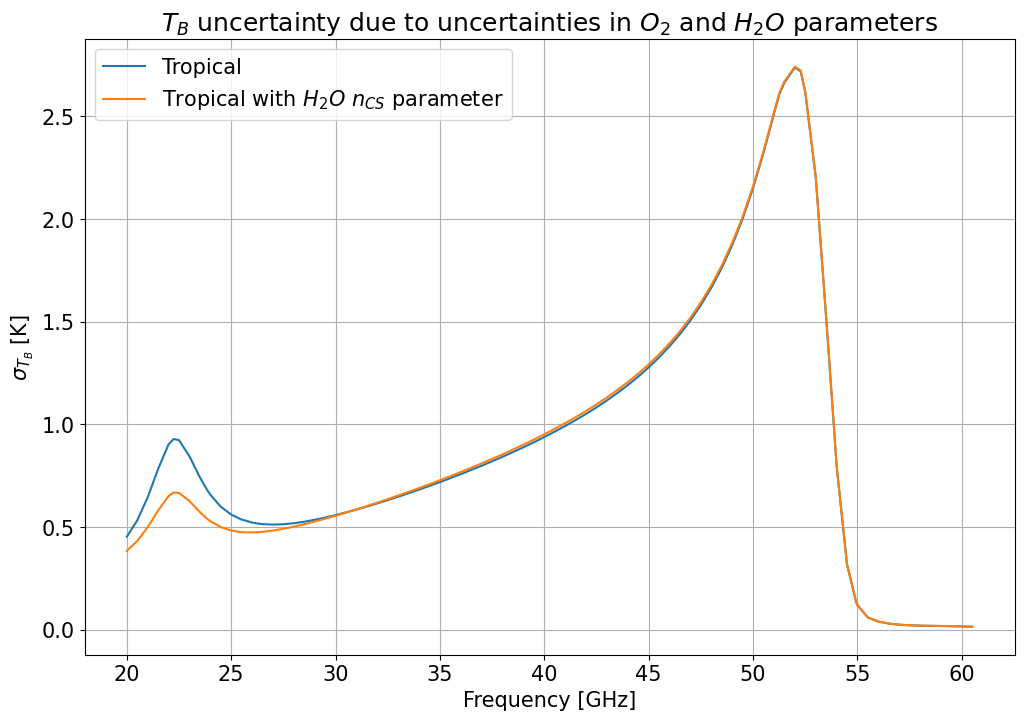

In [14]:
parameters.plot(x='freq', y=['sigma_tb', 'sigma_tb_with_con_Xs'],
            title="${T_B}$ uncertainty due to uncertainties in ${O_2}$ and ${H_2 O}$ parameters",
            xlabel='Frequency [GHz]', ylabel='$\sigma_{T_B}$ [K]',
            label=[atm[atmp.TROPICAL], atm[atmp.TROPICAL] + ' with ${H_2 O}$ ${n_{CS}}$ parameter'], figsize=(12,8))
plt.grid()